In [42]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn import metrics
from sklearn import preprocessing
import holidays

<h1>MVLR</h1>

**Inhoud**:

- 1. Data
    - 1.1. Load data
    - 1.2. Data manipulation
    - 1.3. Feature selection
    - 1.4. Train, Validation, Test split
    - 1.5. Input and target definition
    - 1.6. Data scaling
- 2. Model
    - 2.1. Model configuration
    - 2.2. Training
    - 2.3. Evaluation
    
    

    

<h1>1. Data</h1>

<h2>1.1. Load data</h2>

In [43]:
# Read CSV file
df_postnl = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0], index_col=[0])

In [44]:
df_postnl

,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
procesdag,,,,
2015-01-02,klant_1,0,0,train
2015-01-02,klant_100,0,0,train
2015-01-02,klant_101,0,0,train
2015-01-02,klant_103,0,0,train
2015-01-02,klant_104,0,0,train
...,...,...,...,...
2020-04-29,klant_95,68,60,test
2020-04-29,klant_96,0,0,test
2020-04-29,klant_97,66,123,test


<h2>1.2. Data manipulation</h2>

In [45]:
# Select every row where cust_id is equal to "klant_125"
custfilter = df_postnl['cust_id'] == 'klant_125'
df_postnl = df_postnl.where(custfilter).dropna()

# Remove data for the year 2020, since we'll not includes this
df_postnl = df_postnl[:'2019'].dropna()

# Delete columns: cust_id and validation column.
df_postnl = df_postnl.drop(['cust_id', 'validation_column'], axis=1)

In [46]:
df_postnl

,aantal_pakketten,aantal_pakketten_volgende_dag
procesdag,,
2015-01-02,2380.0,0.0
2015-01-03,0.0,0.0
2015-01-04,0.0,2410.0
2015-01-05,2410.0,2214.0
2015-01-06,2214.0,2370.0
...,...,...
2019-12-27,5458.0,0.0
2019-12-28,0.0,17.0
2019-12-29,17.0,5365.0


<h2>1.3. Feature selection</h2>

In [47]:
# Add the day of the week and month
df_postnl.insert(loc=1, column='weekdag', value=df_postnl.index.dayofweek)
df_postnl.insert(loc=1, column='maand', value=df_postnl.index.month_name(locale= 'en_US.UTF.8'))
df_postnl = pd.get_dummies(df_postnl, columns=['weekdag', 'maand'])

# Add the amount of packages from last week
df_postnl['aantal_pakketten_vorige_week'] = df_postnl['aantal_pakketten'].shift(7)
df_postnl['aantal_pakketten_vorige_week'].fillna(0, inplace=True)

# Add whether the day is a holiday
holidays = holidays.Netherlands()
df_postnl['is_feestdag'] = df_postnl.index.isin(holidays['2015-01-02':'2019-12-31'])

# Add rolling window statistics
df_postnl['rollend_gemiddelde'] = df_postnl['aantal_pakketten'].rolling(7).mean()
df_postnl['rollend_gemiddelde'].fillna(0, inplace=True)

In [48]:
df_postnl.corr()

,aantal_pakketten,aantal_pakketten_volgende_dag,weekdag_0,weekdag_1,weekdag_2,weekdag_3,weekdag_4,weekdag_5,weekdag_6,maand_April,...,maand_July,maand_June,maand_March,maand_May,maand_November,maand_October,maand_September,aantal_pakketten_vorige_week,is_feestdag,rollend_gemiddelde
aantal_pakketten,1.000000,0.297389,0.379687,0.245953,0.177850,0.163530,0.114456,-0.542152,-0.538779,-0.016544,...,0.026510,-0.020245,-0.025039,-0.023974,0.030808,0.033825,0.000543,0.902742,-0.121581,0.348728
aantal_pakketten_volgende_dag,0.297389,1.000000,0.246184,0.175751,0.163798,0.114589,-0.541551,-0.538180,0.379855,-0.012057,...,0.031289,-0.021376,-0.027164,-0.026532,0.026031,0.035165,0.005943,0.301684,-0.009883,0.310441
weekdag_0,0.379687,0.246184,1.000000,-0.166880,-0.166507,-0.166507,-0.166880,-0.166880,-0.166880,0.003123,...,0.004676,-0.002576,-0.006553,-0.000938,-0.002576,0.004676,-0.002576,0.376532,0.032168,0.000124
weekdag_1,0.245953,0.175751,-0.166880,1.000000,-0.166507,-0.166507,-0.166880,-0.166880,-0.166880,-0.002576,...,-0.000938,-0.002576,-0.000938,0.004676,-0.002576,0.004676,-0.002576,0.246144,-0.012933,0.000006
weekdag_2,0.177850,0.163798,-0.166507,-0.166507,1.000000,-0.166134,-0.166507,-0.166507,-0.166507,-0.002111,...,-0.000462,-0.002111,-0.000462,0.005161,0.003597,-0.000462,-0.002111,0.179913,-0.027847,-0.000347
weekdag_3,0.163530,0.114589,-0.166507,-0.166507,-0.166134,1.000000,-0.166507,-0.166507,-0.166507,-0.002111,...,-0.006086,0.003597,0.005161,-0.000462,0.003597,-0.000462,-0.002111,0.165576,0.002269,0.003465
weekdag_4,0.114456,-0.541551,-0.166880,-0.166880,-0.166507,-0.166507,1.000000,-0.166880,-0.166880,-0.002576,...,-0.000938,0.003123,0.004676,-0.000938,0.003123,-0.006553,0.003123,0.110894,0.002101,-0.001083
weekdag_5,-0.542152,-0.538180,-0.166880,-0.166880,-0.166507,-0.166507,-0.166880,1.000000,-0.166880,0.003123,...,-0.000938,0.003123,-0.000938,-0.006553,-0.002576,-0.000938,0.003123,-0.540933,-0.012933,-0.001083
weekdag_6,-0.538779,0.379855,-0.166880,-0.166880,-0.166507,-0.166507,-0.166880,-0.166880,1.000000,0.003123,...,0.004676,-0.002576,-0.000938,-0.000938,-0.002576,-0.000938,0.003123,-0.537574,0.017134,-0.001076
maand_April,-0.016544,-0.012057,0.003123,-0.002576,-0.002111,-0.002111,-0.002576,0.003123,0.003123,1.000000,...,-0.091169,-0.089552,-0.091169,-0.091169,-0.089552,-0.091169,-0.089552,-0.010534,0.121801,-0.027726


<h2>1.4. Train Validation Test split</h2>

In [49]:
# Split train and test
train = df_postnl[:'2017'].dropna()
validation = df_postnl['2018'].dropna()
test= df_postnl['2019'].dropna()

# Define Y train, valid and test
y_train = train.loc[:, 'aantal_pakketten_volgende_dag']
y_valid = validation.loc[:, 'aantal_pakketten_volgende_dag']
y_test = test.loc[:, 'aantal_pakketten_volgende_dag']

# Define X train, valid and test
x_train = train.loc[:, train.columns != 'aantal_pakketten_volgende_dag']
x_valid = validation.loc[:, validation.columns != 'aantal_pakketten_volgende_dag']
x_test = test.loc[:, test.columns != 'aantal_pakketten_volgende_dag']

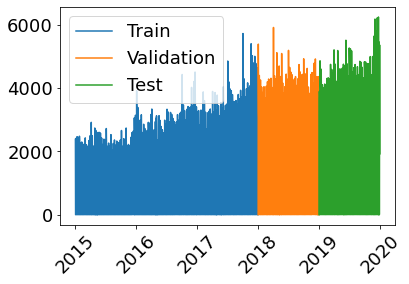

In [50]:
plt.plot(train.index, train['aantal_pakketten'], label='Train')
plt.plot(validation.index, validation['aantal_pakketten'], label='Validation')
plt.plot(test.index, test['aantal_pakketten'], label='Test')
plt.xticks(rotation=45)
plt.legend()

In [51]:
x_valid

,aantal_pakketten,weekdag_0,weekdag_1,weekdag_2,weekdag_3,weekdag_4,weekdag_5,weekdag_6,maand_April,maand_August,...,maand_July,maand_June,maand_March,maand_May,maand_November,maand_October,maand_September,aantal_pakketten_vorige_week,is_feestdag,rollend_gemiddelde
procesdag,,,,,,,,,,,,,,,,,,,,,
2018-01-01,5.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,False,1551.000000
2018-01-02,5392.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11.0,False,2319.714286
2018-01-03,3787.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4648.0,False,2196.714286
2018-01-04,3215.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,3358.0,False,2176.285714
2018-01-05,3022.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2835.0,False,2203.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,4366.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4071.0,False,1638.285714
2018-12-28,4102.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3178.0,False,1770.285714
2018-12-29,0.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,False,1770.285714


<h2>1.5. Data scaling</h2>

In [52]:
# Initialize scaler and fit on the training data
scaler = preprocessing.StandardScaler()

# Transform training and validation set
train_scaled = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
validation_scaled = pd.DataFrame(scaler.fit_transform(validation), index=validation.index, columns=validation.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), index=test.index, columns=test.columns)

# Define Y scaled
y_train_scaled = train_scaled.loc[:, 'aantal_pakketten_volgende_dag']
y_valid_scaled = validation_scaled.loc[:, 'aantal_pakketten_volgende_dag']
y_test_scaled = test_scaled.loc[:, 'aantal_pakketten_volgende_dag']

# Define X scaled
x_train_scaled = train_scaled.loc[:, train_scaled.columns != 'aantal_pakketten_volgende_dag']
x_valid_scaled = validation_scaled.loc[:, validation_scaled.columns != 'aantal_pakketten_volgende_dag']
x_test_scaled = test_scaled.loc[:, test_scaled.columns != 'aantal_pakketten_volgende_dag']

In [53]:
validation_scaled

,aantal_pakketten,aantal_pakketten_volgende_dag,weekdag_0,weekdag_1,weekdag_2,weekdag_3,weekdag_4,weekdag_5,weekdag_6,maand_April,...,maand_July,maand_June,maand_March,maand_May,maand_November,maand_October,maand_September,aantal_pakketten_vorige_week,is_feestdag,rollend_gemiddelde
procesdag,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-1.452466,1.750810,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,-1.454820,0.0,-4.228054
2018-01-02,1.750820,0.796434,-0.412155,2.453412,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,-1.448273,0.0,-0.584327
2018-01-03,0.796435,0.456307,-0.412155,-0.407596,2.453412,-0.407596,-0.407596,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,1.311591,0.0,-1.167351
2018-01-04,0.456305,0.341544,-0.412155,-0.407596,-0.407596,2.453412,-0.407596,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,0.543805,0.0,-1.264183
2018-01-05,0.341541,-1.455419,-0.412155,-0.407596,-0.407596,-0.407596,2.453412,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,0.232524,0.0,-1.137556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1.140727,0.983741,-0.412155,-0.407596,-0.407596,2.453412,-0.407596,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,0.968171,0.0,-3.814317
2018-12-28,0.983744,-1.455419,-0.412155,-0.407596,-0.407596,-0.407596,2.453412,-0.407596,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,0.436672,0.0,-3.188634
2018-12-29,-1.455439,-1.451256,-0.412155,-0.407596,-0.407596,-0.407596,-0.407596,2.453412,-0.407596,-0.299253,...,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,-1.454820,0.0,-3.188634


<h1>2. Model</h1>

In [54]:
# Fit model
model_scaled = LinearRegression()
model_scaled.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [55]:
# Make prediction
pred_scaled = model_scaled.predict(x_valid_scaled)
validation_scaled['aantal_pakketten_volgende_dag'] = pred_scaled

# Descale validation set
validation_prediction = scaler.inverse_transform(validation_scaled.to_numpy())
validation_prediction = pd.DataFrame(validation_prediction, index=validation.index, columns=validation.columns)

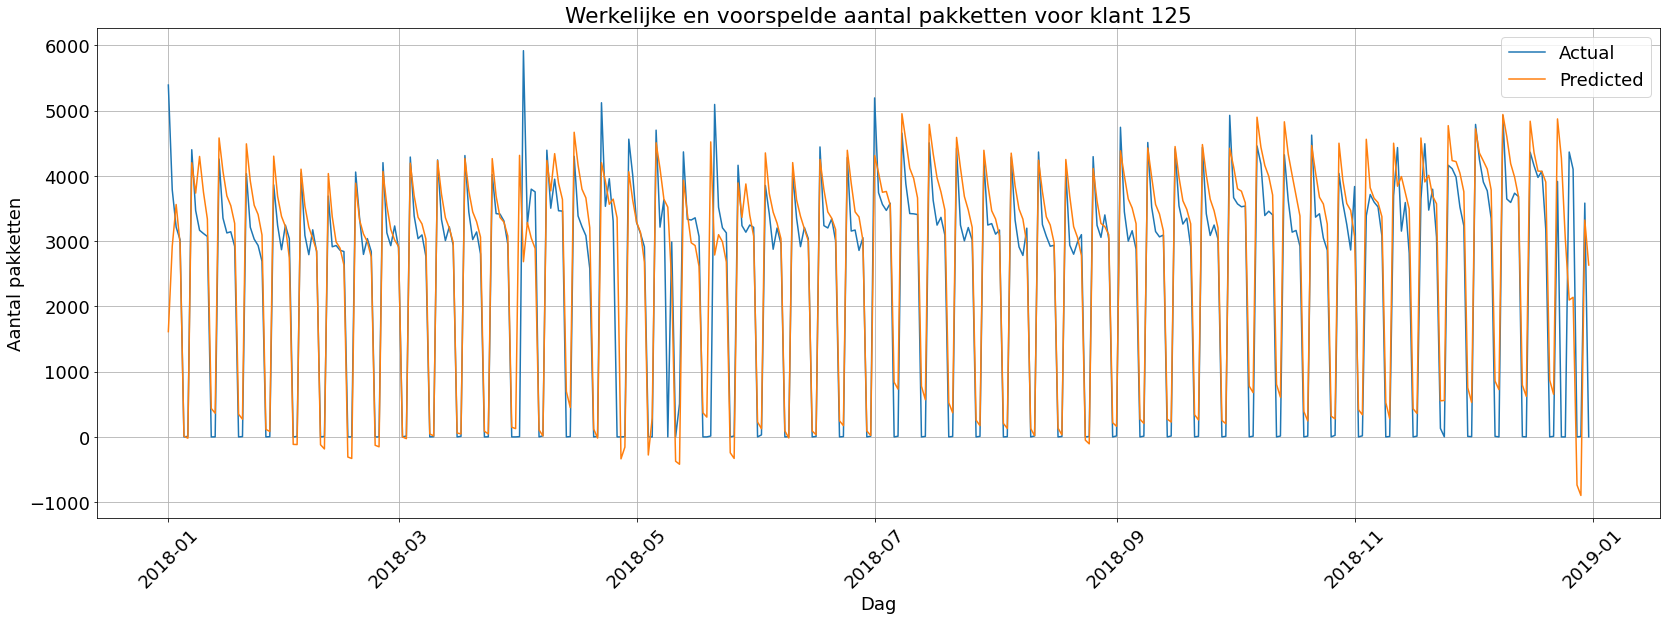

In [56]:
# Plot actual vs. predicted
fig, ax = plt.subplots(figsize=(28,9))
ax.plot(validation.index, validation.loc[:, 'aantal_pakketten_volgende_dag'], label='Actual')
ax.plot(validation.index, validation_prediction.loc[:, 'aantal_pakketten_volgende_dag'], label='Predicted')
ax.set(
    xlabel='Dag',
    ylabel='Aantal pakketten',
    title='Werkelijke en voorspelde aantal pakketten voor klant 125')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

In [57]:
# validate model
rmse_scaled = (np.sqrt(metrics.mean_squared_error(validation.loc[:, 'aantal_pakketten_volgende_dag'], validation_prediction.loc[:, 'aantal_pakketten_volgende_dag'])))
mae_scaled = (metrics.mean_absolute_error(validation.loc[:, 'aantal_pakketten_volgende_dag'], validation_prediction.loc[:, 'aantal_pakketten_volgende_dag']))
r2_scaled = metrics.r2_score(validation.loc[:, 'aantal_pakketten_volgende_dag'], validation_prediction.loc[:, 'aantal_pakketten_volgende_dag'])

print('Root Mean Squared Error:', rmse_scaled)
print('Mean Absolute Error:', mae_scaled)
print('R2_Score', r2_scaled)

Root Mean Squared Error: 737.815339168826
Mean Absolute Error: 435.90606774816166
R2_Score 0.8075204801379219


<h1>Conclusion</h1>

The model seems to perform relatively well once a couple of features have been added, for example packages from last week, month, day, etc and once the data has been scaled.

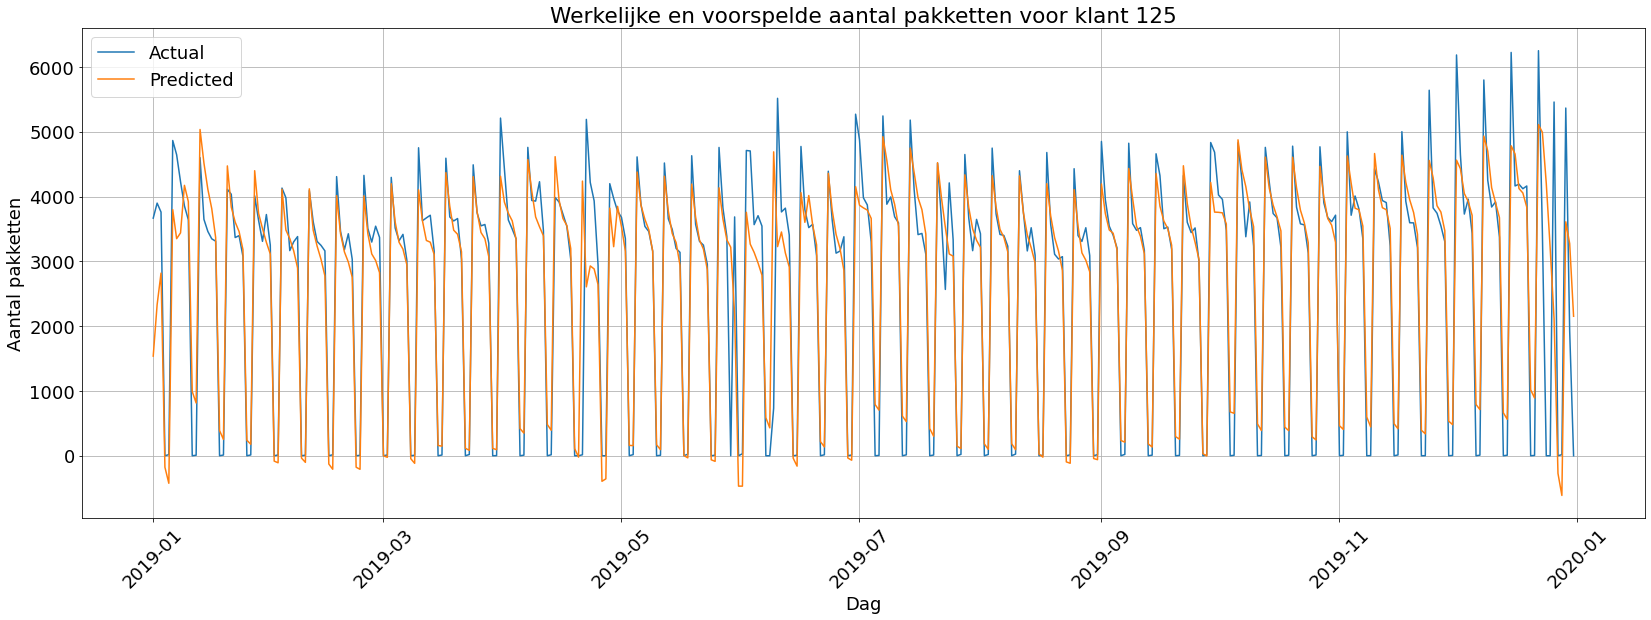

Root Mean Squared Error: 693.3821141491522
Mean Absolute Error: 394.50638401761995
R2_Score 0.8577826214275516


In [58]:
# Test the model on the test set
test_pred = model_scaled.predict(x_test_scaled)
test_scaled['aantal_pakketten_volgende_dag'] = test_pred

# Descale test set
test_prediction = scaler.inverse_transform(test_scaled.to_numpy())
test_prediction = pd.DataFrame(test_prediction, index=test.index, columns=test.columns)

# Plot actual vs. predicted
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(28,9))
ax.plot(test.index, test.loc[:, 'aantal_pakketten_volgende_dag'], label='Actual')
ax.plot(test.index, test_prediction.loc[:, 'aantal_pakketten_volgende_dag'], label='Predicted')
ax.set(
    xlabel='Dag',
    ylabel='Aantal pakketten',
    title='Werkelijke en voorspelde aantal pakketten voor klant 125')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

rmse = (np.sqrt(metrics.mean_squared_error(test.loc[:, 'aantal_pakketten_volgende_dag'], test_prediction.loc[:, 'aantal_pakketten_volgende_dag'])))
mae = (metrics.mean_absolute_error(test.loc[:, 'aantal_pakketten_volgende_dag'], test_prediction.loc[:, 'aantal_pakketten_volgende_dag']))
r2 = metrics.r2_score(test.loc[:, 'aantal_pakketten_volgende_dag'], test_prediction.loc[:, 'aantal_pakketten_volgende_dag'])

print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R2_Score', r2)